In [123]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


# DATA IMPORT AND VISUALISATION:


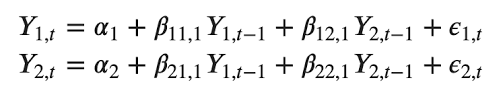

In [170]:
filepath = r"/home/marko/Documents/ElectionLogic/wpd/2020-112.csv"
macro_data = pd.read_csv(filepath)
print(macro_data.shape)  # (123, 8)
macro_data['HDZ'] = macro_data['HDZ'].astype(float)
macro_data.head()

(112, 8)


,HDZ,SDP,BM 365,KH,MOST,HNS-LD,Pametno,DPMS
0,0.346926,0.343840,0.022295,0.063556,0.124263,0.034128,0.018522,0.0
1,0.380882,0.306695,0.046578,0.057382,0.108829,0.034857,0.027337,0.0
2,0.362566,0.274798,0.032207,0.051620,0.118295,0.038244,0.024867,0.0
3,0.368431,0.291981,0.017836,0.083517,0.119427,0.038244,0.030784,0.0
4,0.359582,0.263582,0.026925,0.053781,0.101935,0.045035,0.024353,0.0


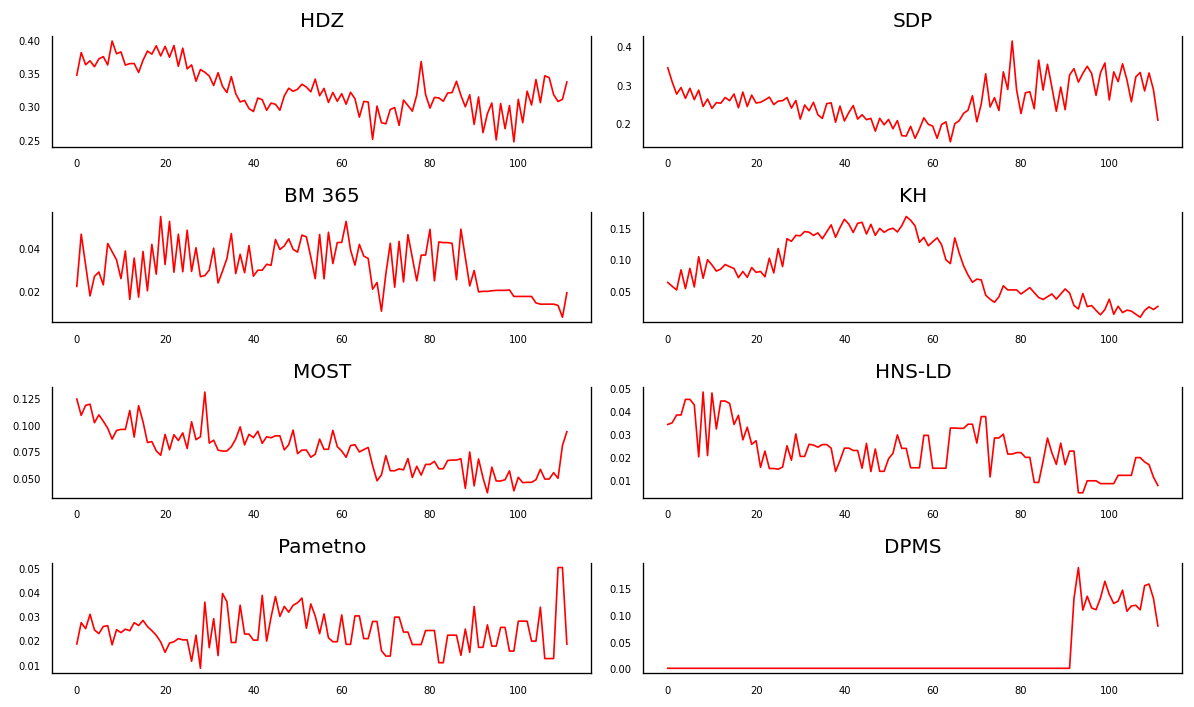

In [171]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# DATA STATIONARITY CHECK:

In [172]:
col_names = macro_data.columns

for i in range (len(col_names)):
    ad_fuller_result = adfuller(macro_data[col_names[i]].diff()[1:])
    
    print(col_names[i])
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')
    
    print('\n---------------------\n')

HDZ
ADF Statistic: -5.313188052867423
p-value: 5.141532576432903e-06

---------------------

SDP
ADF Statistic: -7.445979826852662
p-value: 5.836975941804874e-11

---------------------

BM 365
ADF Statistic: -5.612136406924497
p-value: 1.196810814843021e-06

---------------------

KH
ADF Statistic: -18.845128568295475
p-value: 0.0

---------------------

MOST
ADF Statistic: -11.350555510092844
p-value: 1.0019722576242497e-20

---------------------

HNS-LD
ADF Statistic: -4.717700676957029
p-value: 7.794042560198078e-05

---------------------

Pametno
ADF Statistic: -9.374794204873426
p-value: 7.215711743374515e-16

---------------------

DPMS
ADF Statistic: -6.679357946124233
p-value: 4.382006680341206e-09

---------------------



# DATA CAUSALITY CHECK:

In [173]:
col_names = macro_data.columns

for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i == j: continue
        print(col_names[i] + ' causes ' + col_names[j])
        print('------------------')
        granger_1 = grangercausalitytests(macro_data[[col_names[j], col_names[i]]], 4)
        print('------------------')
        print('------------------')


HDZ causes SDP
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4970  , p=0.4823  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=0.5108  , p=0.4748  , df=1
likelihood ratio test: chi2=0.5096  , p=0.4753  , df=1
parameter F test:         F=0.4970  , p=0.4823  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9429  , p=0.0571  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=6.1661  , p=0.0458  , df=2
likelihood ratio test: chi2=5.9995  , p=0.0498  , df=2
parameter F test:         F=2.9429  , p=0.0571  , df_denom=105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0354  , p=0.1136  , df_denom=102, df_num=3
ssr based chi2 test:   chi2=6.5251  , p=0.0887  , df=3
likelihood ratio test: chi2=6.3373  , p=0.0963  , df=3
parameter F test:         F=2.0354  , p=0.1136  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

# SORTING DATA TO TRAINING AND TESTING:

In [174]:
#macro_data = macro_data.iloc[:200, :]
print(macro_data.shape)

(112, 8)


In [175]:
train_df=macro_data[:-1]
test_df=macro_data[-1:]

In [176]:
print(test_df.shape)

(1, 8)


# FINDING APPROPRIATE LAG VARIABLE:

In [177]:
model = VAR(train_df.diff()[1:])

In [179]:
sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -66.51      -66.31   1.307e-29      -66.43
1     -68.98*     -67.17*  1.107e-30*     -68.25*
2      -68.73      -65.32   1.441e-30      -67.35
3      -68.58      -63.55   1.776e-30      -66.54
4      -68.23      -61.60   2.771e-30      -65.54
-------------------------------------------------


# FITTING DATA INTO MODEL:

In [205]:
var_model = VARMAX(train_df, order=(1,1),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                    Statespace Model Results                                                   
Dep. Variable:     ['HDZ', 'SDP', 'BM 365', 'KH', 'MOST', 'HNS-LD', 'Pametno', 'DPMS']   No. Observations:                  111
Model:                                                                      VARMA(1,1)   Log Likelihood                2646.372
                                                                           + intercept   AIC                          -4948.744
Date:                                                                 Sat, 06 Apr 2024   BIC                          -4482.705
Time:                                                                         18:52:13   HQIC                         -4759.686
Sample:                                                                              0                                         
                                                                                 - 111                  

# FORECASTING + VISUALISATION:

In [206]:
n_forecast = 1
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [207]:
predictions.columns=['hdz_predicted','sdp_predicted', 'bm_predicted', 'kh_predicted','most_predicted', 'hns_predicted', 'pametno_predicted', 'dpms_predicted']
predictions

,hdz_predicted,sdp_predicted,bm_predicted,kh_predicted,most_predicted,hns_predicted,pametno_predicted,dpms_predicted
111,0.319477,0.29658,0.020341,0.029504,0.064008,0.017663,0.02796,0.12143


In [202]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

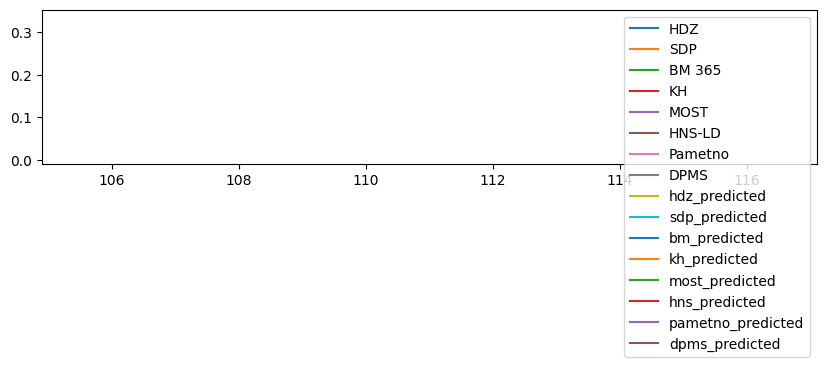

In [203]:
test_vs_pred.plot(figsize=(10,2))

# FORECASTING ERROR CHECK:

In [204]:
from sklearn.metrics import mean_absolute_error
import math 
from statistics import mean

rmse_hdz=mean_absolute_error(predictions['hdz_predicted'],test_df['HDZ'])
print('HDZ ERROR: '+ str(rmse_hdz/mean(test_df['HDZ'])))

rmse_sdp=mean_absolute_error(predictions['sdp_predicted'],test_df['SDP'])
print('SDP ERROR: '+ str(rmse_sdp/mean(test_df['SDP'])))

rmse_bm=mean_absolute_error(predictions['bm_predicted'],test_df['BM 365'])
print('BM 365 ERROR: '+ str(rmse_sdp/mean(test_df['BM 365'])))

rmse_kh=mean_absolute_error(predictions['kh_predicted'],test_df['KH'])
print('KH ERROR: '+ str(rmse_kh/mean(test_df['KH'])))

rmse_most=mean_absolute_error(predictions['most_predicted'],test_df['MOST'])
print('MOST ERROR: '+ str(rmse_most/mean(test_df['MOST'])))

rmse_hns=mean_absolute_error(predictions['hns_predicted'],test_df['HNS-LD'])
print('HNS-LD ERROR: '+ str(rmse_hns/mean(test_df['HNS-LD'])))

rmse_pametno=mean_absolute_error(predictions['pametno_predicted'],test_df['Pametno'])
print('Pametno ERROR: '+ str(rmse_pametno/mean(test_df['Pametno'])))

rmse_dpms=mean_absolute_error(predictions['dpms_predicted'],test_df['DPMS'])
print('DPMS ERROR: '+ str(rmse_dpms/mean(test_df['DPMS'])))

HDZ ERROR: 0.034282634272986535
SDP ERROR: 0.4652166869392504
BM 365 ERROR: 4.971662383186654
KH ERROR: 0.13778850997089506
MOST ERROR: 0.2597830537511536
HNS-LD ERROR: 1.4792558714303126
Pametno ERROR: 0.5764759062291754
DPMS ERROR: 0.5167299905719502
